In [ ]:
#!pip install norse==1.1.0
!pip install mlcroissant==1.0.10
!pip install GitPython==3.1.43
from torchsummary import summary as tch_summary
from mlcroissant import Dataset
from torchvision.transforms import v2 as tch_tf
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from os.path import exists
from IPython.display import clear_output
from PIL import Image
from google.colab import drive

import torch
import torch.nn as nn
import torchvision
#import norse.torch as snn
import numpy as np
import nltk
import gc
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib

drive.mount('/content/drive')
basePath = "/content/drive/My Drive/Colab Notebooks/Computer Vision/Data/proj"
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(dev)
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [ ]:
VEC_LEN = 512

class EncoderSlice(nn.Module):
  def __init__(self):
    super().__init__()
    # Create a sequential model
    self.mdl = nn.Sequential(
        nn.Conv2d(1, 8, 7, 3, 1),    # Convolution layer: 1 input channel, 8 output channels, kernel size 7, stride 3, padding 1
        nn.AvgPool2d(7, 1, 1),        # Average pooling layer: kernel size 15, stride 1, padding 1
        nn.Conv2d(8, 16, 7, 3, 1),    # Convolution layer: 8 input channel, 32 output channels, kernel size 7, stride 3, padding 1
        nn.AvgPool2d(7, 1, 1),        # Average pooling layer: kernel size 7, stride 1, padding 1
        nn.Conv2d(16, 32, 3, 1, 1),   # Convolution layer: 32 input channels, 128 output channels, kernel size 3, stride 1, padding 1
        nn.AvgPool2d(3, 1, 1),        # Average pooling layer: kernel size 3, stride 1, padding 1
        nn.Flatten(),                 # Flatten the output to a 1D tensor
        nn.LazyLinear(VEC_LEN),       # Linear layer that outputs a vector of VEC_LEN
    )

  # NOTE: toggle fine tuning with requires_grad_()

  # Forward pass
  def forward(self, X):
    return self.mdl(X)

# Debug: Prints the modified x and returns it
def dbg(x, apply=lambda x: x):
  print(apply(x))
  return x

# Aggregates multiple EncoderSlice instances
class Encoder(nn.Module):
  def __init__(self, encoders):
    super().__init__()
    self.encs = encoders      # Store the list of encoder slices

  # Forward pass
  def forward(self, X):
    # Split the input tensor and apply each encoder slice
    X = [e(x) for x, e in zip(torch.split(X, 1, dim=1), self.encs)]
    return torch.concat([x.unsqueeze(1) for x in X], dim=1)   # Concatenate the outputs of the encoder slices along the specified dimension

# Decoder of the model
class Decoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.inp = nn.Sequential(
      nn.Flatten(),                         # Flatten the input tensor
      nn.Linear(VEC_LEN * 3, 32 * 32 * 8),  # Linear layer to transform the input
    )
    self.up = nn.Sequential(
      nn.Upsample(64),
      nn.Conv2d(8, 8, 31, 1, 1),            # Convolution layer with kernel size 31
      nn.Upsample(128),
      nn.Conv2d(8, 8, 15, 1, 1),            # Convolution layer with kernel size 15
      nn.Upsample(224),
      nn.Conv2d(8, 3, 3, 1, 1),             # Convolution layer with kernel size 3
    )

  # Forward pass
  def forward(self, X):
    # Process the input through the decoder
    X = self.inp(X).view(-1, 8, 32, 32)     # Reshape the output of the linear layer
    return self.up(X)                       # Pass through the upsampling layers

# Combines the encoder and decoder
class EncDec(nn.Module):
  def __init__(self, enc, dec):
    super().__init__()
    self.enc = enc    # Store the encoder instance
    self.dec = dec    # Store the decoder instance

  # Forward pass
  def forward(self, X):
    X = self.enc(X)   # Encode the input
    X = self.dec(X)   # Decode the result
    return X

# torchsummary does not like the encoder. Is it because of cat?
tch_summary(EncoderSlice(), (1, 224, 224))
tch_summary(Decoder(), (3, VEC_LEN))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 74, 74]             400
         AvgPool2d-2            [-1, 8, 70, 70]               0
            Conv2d-3           [-1, 16, 22, 22]           6,288
         AvgPool2d-4           [-1, 16, 18, 18]               0
            Conv2d-5           [-1, 32, 18, 18]           4,640
         AvgPool2d-6           [-1, 32, 18, 18]               0
           Flatten-7                [-1, 10368]               0
            Linear-8                  [-1, 512]       5,308,928
Total params: 5,320,256
Trainable params: 5,320,256
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 0.97
Params size (MB): 20.30
Estimated Total Size (MB): 21.46
----------------------------------------------------------------
------------------------------------

In [ ]:
!mkdir dump -p
datadir = 'dump/'

# Load the dataset
ds = Dataset(jsonld="https://huggingface.co/api/datasets/nlphuji/flickr30k/croissant")
rec = ds.records("TEST")  # Get the records from the 'TEST' subset
imgs = []                 # list of image paths
img_caption_map = {}      # map of images to caption

# Iterate over the records with a progress bar
for i, x in enumerate(tqdm(rec)):
  p = f'{datadir}{i}.jpg'
  if not exists(p):
    with open(p, 'wb') as f:
      x['TEST/image'].save(f)            # Save the image from the dataset to the file
  imgs += [p]                            # Add the path to the list
  img_caption_map[p] = x['TEST/caption'] # Map path to caption
del ds, rec                              # Delete the dataset and records. They're already loaded

img_tforms = tch_tf.Compose([    # Define a series of transformations for the images
  tch_tf.ToImage(),               # Convert to image
  tch_tf.Resize((224, 224)),      # Resize the image to 224x224 pixels
  tch_tf.ToDtype(torch.float32, scale=True),  # Convert to float32 and scale pixel values
  tch_tf.RGB(),                   # Ensure the image is in RGB format
])

# Loads the images
class ImgLoader(torch.utils.data.Dataset):
  def __init__(self, blob):
    self.blob = blob                  # Store the list of image paths

  # Return the number of images
  def __len__(self):
    return len(self.blob)

  # Load an image
  def __getitem__(self, i):
    with Image.open(self.blob[i]) as img:   # Open the image
      i = img_tforms(img).to(dev)          # Apply transformations and move to the specified device
      return (i, i)                         # Return the concatenated tensor as both inputs and targets

# Split data into training, validation, and testing sets
def train_val_test_splitter(blob, val_factor=0.01, test_factor=0.1, random=1):
  # Shuffle the indices to ensure randomness
  indexes = np.arange(len(blob))
  np.random.default_rng(random).shuffle(indexes)

  # Calculate split indices
  val_i = int(len(indexes) * val_factor)                  # Number of samples
  tst_i = len(indexes) - int(len(indexes) * test_factor)  # Starting index for test samples
  # Create lists for training, validation, and testing sets
  val = indexes[:val_i]
  train = indexes[val_i:tst_i]
  test = indexes[tst_i:]
  return [blob[i] for i in train], [blob[i] for i in val], [blob[i] for i in test]  # Return the splits

# Create lists for training, validation, and testing sets and apply the DataLoader creation for each split
timgs, vimgs, teimgs = train_val_test_splitter(imgs)
train, val, test = map(lambda x: (
    DataLoader(ImgLoader(x),
               batch_size=128,
               shuffle=True,        # Shuffle the data at every epoch
               generator=torch.Generator(device=dev))),
    (timgs, vimgs, teimgs))  # Split the images using the defined function


  -  [Metadata(flickr30k)] Property "http://mlcommons.org/croissant/citeAs" is recommended, but does not exist.
  -  [Metadata(flickr30k)] Property "https://schema.org/datePublished" is recommended, but does not exist.
  -  [Metadata(flickr30k)] Property "https://schema.org/license" is recommended, but does not exist.
  -  [Metadata(flickr30k)] Property "https://schema.org/version" is recommended, but does not exist.
  -  `description` has cardinality `ONE`, but got a list
  -  `source` has cardinality `ONE`, but got a list


0it [00:00, ?it/s]

Streaming output truncated to the last 5000 lines.


In [ ]:
# pyplot preview code taken from https://stackoverflow.com/a/52866695
enc = Encoder([EncoderSlice() for _ in range(3)])   # Create an encoder consisting of 3 slices
dec = Decoder()
mdl = EncDec(enc, dec)    # Combine the encoder and decoder into a single model
opt = torch.optim.Adam(mdl.parameters(), foreach=True)  # Initialize the Adam optimizer
loss = nn.HuberLoss(reduction='sum')     # Define the loss function
gc.collect()              # Free memory
torch.cuda.empty_cache()  # Clear cached memory

# Begin training
for epoch in range(30):
  if exists(f'{basePath}/enc_30.pt'):
    break

  print(f'{epoch + 1} / 30')
  for X, y in tqdm(train):
    opt.zero_grad()         # Reset the gradients
    # Forward pass
    pred = mdl.forward(X)   # Compute predictions
    loss_ = loss(pred, y)   # Calculate the loss

    # Backward pass
    loss_.backward()
    opt.step()              # Update model parameters

  # save model
  torch.save(enc, f'{basePath}/enc_{epoch + 1:01d}.pt')
  torch.save(dec, f'{basePath}/dec_{epoch + 1:01d}.pt')

  # Disable gradient calculation for validation
  with torch.no_grad():
    for X, y in val:
      # Forward pass
      weights = enc.forward(X)    # Get the encoded weights
      pred = dec.forward(weights)
      weights = weights.permute(0, 1, 2).cpu().numpy()
      pred = pred.permute(0, 2, 3, 1).cpu().numpy()
      X = X.permute(0, 2, 3, 1).cpu().numpy()
      y = y.permute(0, 2, 3, 1).cpu().numpy()
      plts, ax = plt.subplots(3, 2)
      wplt, wax = plt.subplots(3, 3)
      plts.set_size_inches(8, 9)
      wplt.set_size_inches(6, 6)
      for i in range(3):
        ax[i, 0].imshow(X[i, :, :, :])
        ax[i, 1].imshow(pred[i, :, :, :])
        w = weights[i, :, :]
        [wax[i, g].imshow(((w[g] - np.min(w[g])) / (np.max(w[g]) - np.min(w[g]))).reshape(VEC_LEN // 16, -1)) for g in range(3)]
        print(f'{i} channels:',
              f'{np.min(w[0]):0.7f} to {np.max(w[0]):0.7f},',
              f'{np.min(w[1]):0.7f} to {np.max(w[1]):0.7f},',
              f'{np.min(w[2]):0.7f} to {np.max(w[2]):0.7f}')
      plt.show()
      break



In [ ]:
# extract singular nouns
stemmer = nltk.stem.porter.PorterStemmer()
img_nouns_map = {}
for (img, sents) in tqdm(img_caption_map.items()):
  img_nouns_map[img] = set( # each image maps to a set of the following elements
              ((stemmer.stem(word)        # 5 make words not plural
               if pos == 'NNS' else word) # 6 it's a singular
               for word, pos in nltk.tag.pos_tag(                     # 3 tag parts of speech
                   nltk.tokenize.word_tokenize(                       # 2 extract words
                       ' '.join((x.decode('utf-8') for x in sents)))) # 1 for all sentences
               if pos in ['NN', 'NNS']))                              # 4 if the word is a noun


  0%|          | 0/31014 [00:00<?, ?it/s]

In [ ]:
# vector similarity matrix
def vsm(A, B):
  return 1 - np.sqrt(1 -
      ((2 * np.sum([a * b for a, b in zip(A, B)])) /
      (np.sum(np.square(A)) + np.sum(np.square(B)))))

enc = torch.load(f'{basePath}/enc_30.pt', map_location=dev)
# this is a semi failed thing that needed to be commented out for reasons.
# generate vectors
# img_vecs = []
# with torch.no_grad():
#   for imgname in tqdm(teimgs):
#     with Image.open(imgname) as img:                      # Open the image
#       img = img_tforms(img).to(dev).unsqueeze(0)          # Apply transformations and move to the specified device
#     img_vecs += [(imgname, enc.forward(img).cpu().numpy())] # generate vector
#
# # find similarities
# img_pos = {iname[0]: i for i, iname in enumerate(img_vecs)}
# pos_img= {y: x for x, y in img_pos.items()}
# sim_mat = np.ones((len(img_vecs), len(img_vecs)), np.float64)
# for r in tqdm(range(len(img_vecs) - 1)):
#   for l in range(r + 1, len(img_vecs)):
#     sim = vsm(img_vecs[r][1], img_vecs[l][1])
#     sim_mat[l][r] = sim
#     sim_mat[r][l] = sim
# print(sim_mat)

<ipython-input-6-a2fb02bb66ea>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  enc = torch.load(f'{basePath}/enc_30.pt', map_location=dev)


In [ ]:
# do testing on cifar10
cifar10_test = torchvision.datasets.CIFAR10(root='./cifar10', train=False,
                                       download=True, transform=img_tforms)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# generate vec groups
vec_groups = [[] for _ in range(len(classes))]
with torch.no_grad():
  for X, y in tqdm((cifar10_test)):
    vec_groups[y].append((len(vec_groups[y]), enc.forward(X.unsqueeze(0)).cpu().numpy()))

# plot similarity
# (same, diff) where same is average similarity across own group,
# while diff is similarity across not own group
sims = np.zeros((10, 1000, 4), np.float32) # (same, diff, group)
groups = set(range(10))
for i in range(10):
  sims[i, :, 2] = float(i)
c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
for i_vec in tqdm(range(999)):
  for group in range(len(vec_groups)):
    for s_vec in range(i_vec + 1, 1000):
      sims[group, i_vec, 3] = float(vec_groups[group][i_vec][0])
      # calc same
      same = vsm(vec_groups[group][i_vec][1], vec_groups[group][s_vec][1])
      sims[group, i_vec, 0] += same
      sims[group, s_vec, 0] += same
      # calc diff
      for ogroup in range(group + 1, 10):
        diff = vsm(vec_groups[group][i_vec][1], vec_groups[ogroup][s_vec][1])
        sims[group, i_vec, 1] += diff
        sims[ogroup, s_vec, 1] += diff
sims = sims.reshape(-1, 4)
sims[:, 0] /= 999.0
sims[:, 1] /= 9999.0

Files already downloaded and verified


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

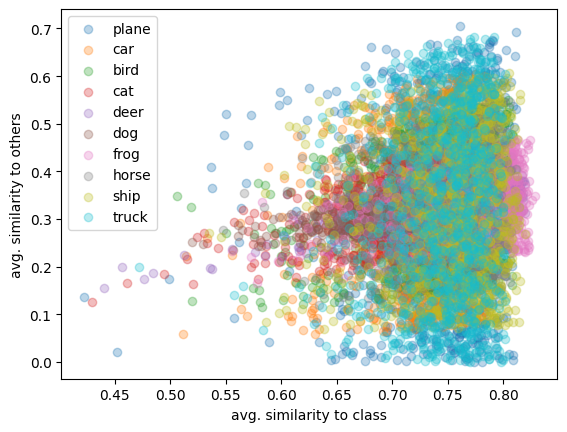

In [ ]:
plt.xlabel('avg. similarity to class')
plt.ylabel('avg. similarity to others')
for cl in range(10):
  sl = sims[sims[:, 2] == cl]
  plt.scatter(sl[:, 0], sl[:, 1], c=c[cl], label=classes[cl], alpha=0.3)
plt.legend()
plt.show()

<ipython-input-9-c1c12b0ecd8e>:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  [x.set_xticklabels(classes) for x in ax]
<ipython-input-9-c1c12b0ecd8e>:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  [x.set_xticklabels(classes) for x in ax]


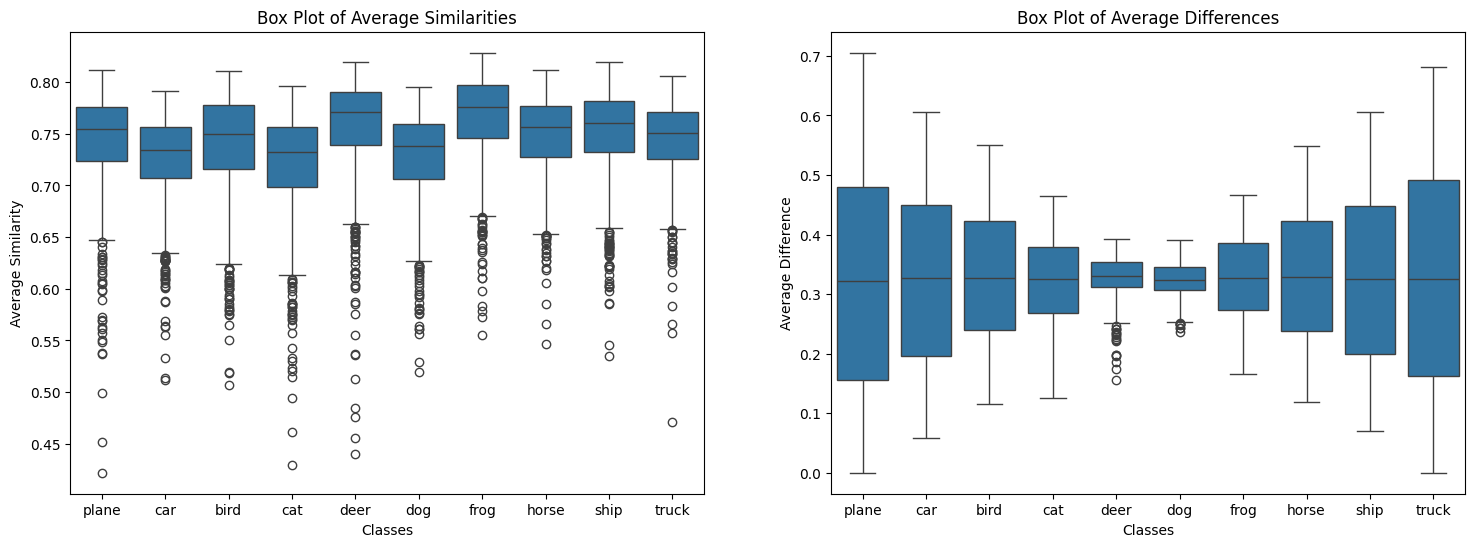

In [ ]:
# Create a box plot
plts, ax = plt.subplots(1, 2)
plts.set_size_inches(18, 6)
ax[0].set_title('Box Plot of Average Similarities')
ax[1].set_title('Box Plot of Average Differences')
[x.set_xlabel('Classes') for x in ax]
ax[0].set_ylabel('Average Similarity')
ax[1].set_ylabel('Average Difference')
[x.set_xticklabels(classes) for x in ax]
sns.boxplot(y=sims[:, 0], x=sims[:, 2].astype(np.uint32), ax=ax[0])
sns.boxplot(y=sims[:, 1], x=sims[:, 2].astype(np.uint32), ax=ax[1])
plt.show()

Text(0.5, 1.0, 'Reference vector similarity')

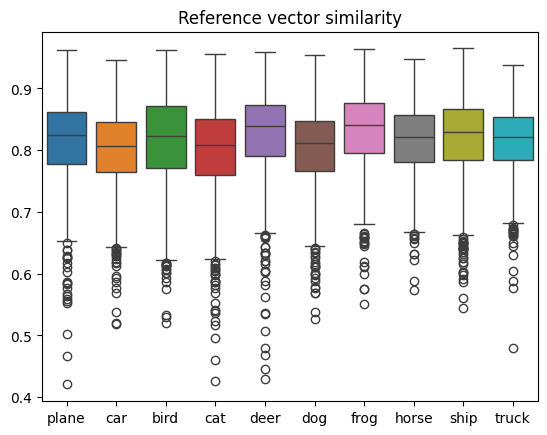

In [ ]:
# select top similar vectors
sims = sims[sims[:, 0].argsort()]
selects = [[] for _ in range(10)]
for x in reversed(sims):
  group = int(x[2])
  if len(selects[group]) < 3:
    selects[group] += [int(x[3])]
  if all((len(x) >= 3 for x in selects)):
    break

# average top similar vectors
avg_sel = []
for group, sels in enumerate(selects):
  avg_sel += [np.mean([vec_groups[group][i][1] for i in sels], axis=0)]
avg_sims = np.zeros((1000, 10), dtype=np.float32)

# plot similarity
for group, sim in enumerate(avg_sel):
  for i, vec in enumerate(vec_groups[group]):
    avg_sims[i][group] = vsm(sim, vec[1])
sns.boxplot(data=avg_sims)
plt.xticks(range(10),labels=classes)
plt.title("Reference vector similarity")

Text(0.5, 1.0, 'Reference vector differences')

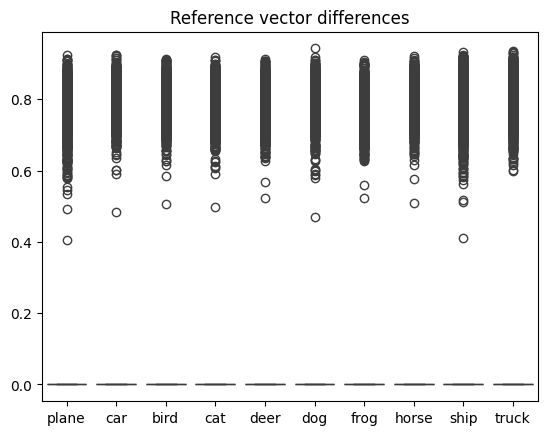

In [ ]:
# plot differences
avg_diffs = np.zeros((9000, 10), dtype=np.float32)
for group, sim in enumerate(avg_sel):
  for vecs in [x for i, x in enumerate(vec_groups) if i != group]:
    for i, vec in enumerate(vecs):
      avg_diffs[i][group] = vsm(sim, vec[1])
sns.boxplot(data=avg_diffs[:, :])
plt.xticks(range(10),labels=classes)
plt.title("Reference vector differences")